### PLL Implementation

The following phase-locked loop (PLL) system demonstrates the fundamental components used to build a PLL and its application within a quadrature phase shift keying (QPSK) system. PLLs are used in communication systems for synchronizing an output signal with an input reference signal, particularly for correcting small, unknown phase and frequency offsets in the received signal. The first a phase detector module calculates the phase difference between the input reference signal and the PLL output, representing the instantaneous phase error. This phase error is then processed through a loop filter and subsequently fed into a digital direct synthesizer (DDS) that generates the corrected output signal. The process is illustrated in figure 1 below where both the input and output signals are represented as complex exponentials.

<div style="text-align: center;">
    <img src="./images/PLL/pll_diagram.png" alt="" width="600" />
    <p style="text-align: center;">Figure 1: PLL Subsystem Architecture</p>
</div>

The progression of each of these modules is discussed in the subsequent sections to demonstrate their functionality as well as the capablities of the accompanying signal processing library.

#### System Configuration

Before describing the PLL further, the developed signal processing library, along with two additional libraries for plotting and linear algebra, must be imported. These libraries will be useful for the later visualization of the system's internal variables.

In [1]:
from helper_functions import sp_library as sp
import numpy as np
import matplotlib.pyplot as plt

#### Phase Error Detector

The phase error detector module takes two reference signals as input, computes their respective phases, and outputs the phase difference between them. This phase difference, known as the phase error, is used for synchronizing the output signal with the input reference signal in a PLL. To determine the phase of each signal, the module calculates the inverse tangent, using the CORDiC algorthim (see *CORDiC.ipynb*), of the ratio between the imaginary and real components of the complex signal points. This operation yields the phase angle of the signal within the range of $\pi$ to $-\pi$. However, because the inverse tangent function alone does not account for the correct quadrant of the signal in the complex plane, additional adjustments are made based on the sign of the real and imaginary components. This ensures that the calculated phase accurately reflects the position of the signal in its respective quadrant. This process is represented mathmatically below.

$$
\theta _o\left(nT\right)\:=\:\tan ^{-1}\left(\frac{x_{imag}\left(nT\right)}{x_{real}\left(nT\right)}\right) \quad \quad \quad \theta _i\left(nT\right)\:=\:\tan ^{-1}\left(\frac{x_{imag}\left(nT\right)}{x_{real}\left(nT\right)}\right)
$$

$$
e\left(nT\right)=\Delta \:\theta \:\left(nT\right)=\theta \:_o\left(nT\right)-\theta \:_i\left(nT\right)
$$

where:
- $i$ represents the input reference signal,
- $o$ represents the output signal,
- $nT$ is the instantaneous sample,
- $e(nT)$ is the detected phase error.

The following excerpt shoes the phase detector implementation later used in the full PLL subsystem. 

In [2]:
def phase_error_detector(sample1, sample2):
    angle = np.angle(sample2) - np.angle(sample1)
    if angle > np.pi:
        angle -= 2 * np.pi
    elif angle < -np.pi:
        angle += 2 * np.pi
    return angle

# test case 1
sample1 = 0
sample2 = 1 + 1j
ped_output = phase_error_detector(sample1, sample2)
print(f"\nTest case 1 output: {np.degrees(ped_output)} deg")

# test case 2
sample1 = 1 - 1j
sample2 = 1 + 1j
ped_output = phase_error_detector(sample1, sample2)
print(f"Test case 2 output: {np.degrees(ped_output)} deg\n")


Test case 1 output: 45.0 deg
Test case 2 output: 90.0 deg



#### Loop Filter

The loop filter module provides stability for the overall PLL system by shaping the transient response. During instantiation of a PLL system, a loop bandwidth and damping factor are defined as parameters shaping this transient response. The loop bandwidth specifies the speed at which the PLL will converge towards matching the input reference signal, setting a wider loop bandwidth allows the PLL to respond more rapidly respond to input frequency changes but introduces more internal noise. The damping factor specifies how the oscillations decay in the transient response when a input frequency change is introduced. Together these parameters categorize the loop filter coefficients $K_1$ and $K_2$ seen in figure 2.

<div style="text-align: center;">
    <img src="./images/PLL/pll_loop_filter_diagram.png" alt="" width="500" />
    <p style="text-align: center;">Figure 2: Loop Filter Internal Architecture</p>
</div>

The derivations of $K_1$ and $K_2$ are shown below
$$
K_1 = \frac{4 \xi \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2} \quad \quad \quad K_2 = \frac{4 \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}
$$

where:
- $B_n$ represents the loop bandwidth (usually normalized for the sample rate $f_s$),
- $\zeta$ represents the damping factor,
- $T_s$ is the sampling period of the system.

The following excerpt shoes the loop filter coeffiencient calculations later used in the full PLL subsystem. 

In [3]:
def compute_loop_constants(fs, lb, df):
    denominator = 1 + ((2 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) + ((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2
    K1 = ((4 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) / denominator
    K2 = (((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2) / denominator
    return K1, K2

sample_rate = 8
loop_bandwidth = 0.02 * sample_rate
damping_factor = 1 / np.sqrt(2)
k1, k2 = compute_loop_constants(sample_rate, loop_bandwidth, damping_factor)

print("\nLoop Filter Configuration Parameters")
print(f"Sample Rate: {sample_rate}")
print(f"Loop Bandwidth: {loop_bandwidth}")
print(f"Damping Factor: {np.round(damping_factor, 5)}")
print(f"Loop Filter Coefficient K1: {np.round(k1, 5)}")
print(f"Loop Filter Coefficient K2: {np.round(k2, 5)}\n")


Loop Filter Configuration Parameters
Sample Rate: 8
Loop Bandwidth: 0.16
Damping Factor: 0.70711
Loop Filter Coefficient K1: 0.05193
Loop Filter Coefficient K2: 0.00035



#### Direct Digital Synthesizer

The direct digital synthesizer (DDS) module generates a complex sinusoidal output signal using the filtered phase error from the loop filter. This process is illustrated in figure 3, which employs a feedback architecture. In this setup, the previous output, the current output, and a estimated reference frequency are summed and then fed into a complex multiplier. The complex multiplier operates on two separate channels: the first applies a cosine function to the input, while the second applies a sine function which are both performed via the cordic algorithm. This approach allows the DDS to precisely generate the required output signal which is required for maintaining phase and frequency synchronization throughout transmission.

<div style="text-align: center;">
    <img src="./images/PLL/pll_dds_diagram.png" alt="" width="600" />
    <p style="text-align: center;">Figure 3: DDS Internal Architecture</p>
</div>

Figure 3 shows a gain, $G$, being applied to the DDS input. This gain is used to normalize the output of the loop filter, ensuring that the phase error signal is appropriately scaled before it is fed into the DDS. The normalization provided by $G$ helps to maintain consistent output amplitude from the DDS, preventing excessive signal levels that could lead to distortion or instability in the PLL system. The following excerpt shoes the DDS implementation later used in the full PLL subsystem. 

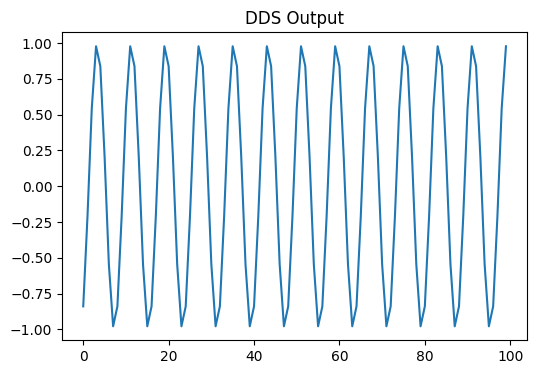

In [4]:
def DDS(fs, n, v, f0, k0):
    phase = v * k0
    output = np.exp(1j * (2 * np.pi * (f0 / fs) * n + phase))
    return output

fs = 8 # sample rate
n = np.arange(0, 100) # sample indicies
v = 1.0 # defined loop filter output
k0 = 1.0 # normalization coefficient
f0 = 10 # assumed frequency of input

output = DDS(sample_rate, n, v, k0, f0)

plt.figure(figsize=(6, 4))
plt.plot(np.real(output))
plt.title("DDS Output")
plt.show()

#### PLL Simulation

With all the submodules defined, the complete PLL subsystem can now be tested. The PLL is implemented as a class within the helper functions code and operates in stream mode, where each input sample of the complex reference signal produces a corresponding output sample. For testing, a reference signal is generated, and arrays are initialized to track the PLL's internal variables, including the detected phase error, loop filter output, and the input and output reference signal samples. This setup allows for detailed analysis of the PLL's performance throughout the simulation.

In [15]:
sample_rate = 500
n = np.arange(0,1000)

input_freq = 10
input_phase = np.pi / 4
input_signal = np.exp(1j * ((2 * np.pi * (input_freq) / sample_rate) * n + (input_phase)))

Next the PLL module can be instantiated using the system sample rate as well as a specified loop bandwidth and damping factor. A varietry of arrays are also defined to store records of the PLL's internal variables.

In [16]:
loop_bandwidth = 0.04 * fs
damping_factor = 1 / np.sqrt(2)
pll = sp.PLL(fs, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor)

# print loop filter configuration
print("\nPLL Configuration Parameters")
print(f"K1: {np.round(pll.k1, 5)}")
print(f"K2: {np.round(pll.k2, 5)}\n")

# pll internal records
pll_input = []
pll_output = []
pll_detected_phase_record = []
pll_error_record = []


PLL Configuration Parameters
K1: 0.11625
K2: 3.73214



Finally the simulation can be run as well as the resulting recorded input, output, and measured phase errors plotted.

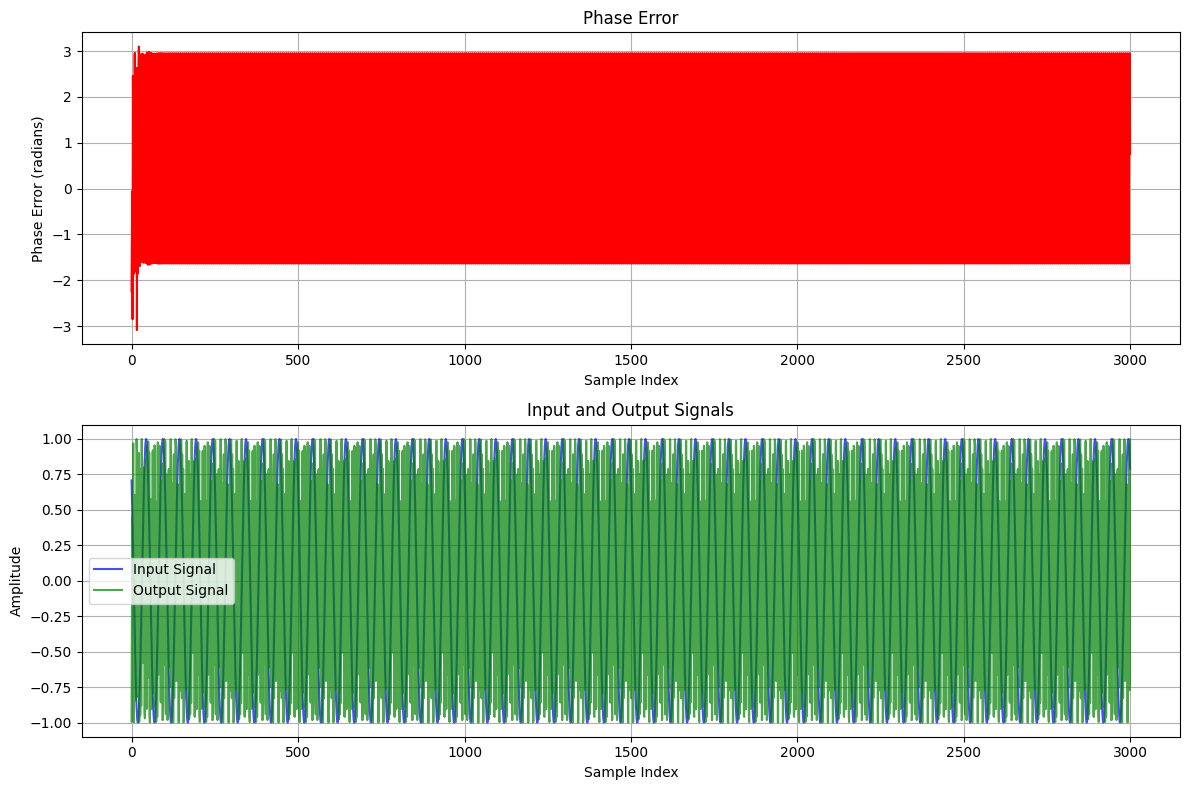

In [19]:
for i in range(len(n)):
    # insert the new sample into the PLL
    output_signal = pll.insert_new_sample(input_signal[i], i)
    
    # record detected phase and error
    detected_phase = pll.get_current_phase()
    error = pll.phase_detector(output_signal, input_signal[i])

    # update records
    pll_input.append(input_signal[i])
    pll_output.append(output_signal)
    pll_detected_phase_record.append(detected_phase)
    pll_error_record.append(error)

# plotting the phase error and input/output signal results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(pll_error_record, label='Phase Error', color='r')
plt.title('Phase Error')
plt.xlabel('Sample Index')
plt.ylabel('Phase Error (radians)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.real(pll_input), label='Input Signal', color='b', alpha=0.7)
plt.plot(np.real(pll_output), label='Output Signal', color='g', alpha=0.7)
plt.title('Input and Output Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

&nbsp;
### QPSK Integration

The PLL described above serves as the foundation for phase and frequency synchronization in a quadrature communication receiver. Figure 4 below demonstrates its integration into a QPSK system, where complex signal points are extracted both before and after the decision module, and phase corrections are applied after the downsampling stage.

<div style="text-align: center;">
    <img src="./images/PLL/pll_full_system_diagram.png" alt="" width="1000" />
    <p style="text-align: center;">Figure 4: QPSK Receiver PLL Placement</p>
</div>

&nbsp;
### Transmitter

The QPSK transmitter can be simulated similarly to that in the QPSK example (see *QPSK.ipynb*), with the added step of concatenating the previously described unique word with the generated symbol sequence. This process is summarized below.

#### Unique Word Resolution

The timing error detector operates on complex points sampled before and after the decision process, leveraging the assumption that the system is already close to the correct symbol. By comparing the received point with the estimated symbol, the system can determine the phase offset, allowing the PLL to adjust its internal phase to match the received signal's phase. However, this approach introduces ambiguity, as the estimated point might be a rotated version of the actual message.

To resolve this ambiguity, a unique word— a predefined sequence of symbols that is distinct for each possible symbol in the modulation scheme's constellation—is used. This unique word allows the PLL to lock onto the nearest estimated point and then correctly align the constellation based on the received sequence. An example of an 8-symbol, 16-bit unique word for QPSK is shown below.

In [39]:
unique_word = [0, 1, 2, 3, 0, 1, 2, 3]
phase_ambiguities = {
    "01230123": 0,
    "20312031": np.pi/2,
    "32103210": np.pi,
    "13021302": 3*np.pi/2
}

#### Bit to Symbol Mapping

In [40]:
# SYSTEM PARAMETERS
qpsk_constellation = [[complex( np.sqrt(1) +  np.sqrt(1)*1j), 3], 
                      [complex( np.sqrt(1) + -np.sqrt(1)*1j), 2], 
                      [complex(-np.sqrt(1) + -np.sqrt(1)*1j), 0], 
                      [complex(-np.sqrt(1) +  np.sqrt(1)*1j), 1]]
fs = 8 # sample rate
fc = .25 * fs # carrier frequency
input_message_ascii = "this is a qpsk transceiver test!"

# mapping the ascii characters to binary
input_message_bins = ''.join(sp.string_to_ascii_binary(input_message_ascii))

# grouping the binary into blocks of two bits
input_message_blocks = [input_message_bins[i:i+2] for i in range(0, len(input_message_bins), 2)]

# mapping each block to a symbol in the constellation
input_message_symbols = [int(bin2, 2) for bin2 in input_message_blocks]

#### Unique Word and Header

In [41]:
# adding unqiue word to symbols
input_message_symbols = unique_word + input_message_symbols

bits_to_amplitude = {bit: amplitude for amplitude, bit in qpsk_constellation}

# inphase channel symbol mapping
xk = np.real([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# quadrature channel symbol mapping
yk = np.imag([bits_to_amplitude[symbol] for symbol in input_message_symbols])

# adding header to each channel
header = np.ones(25)
xk = np.concatenate([header, xk])
yk = np.concatenate([header, yk])

#### Upsampling

In [42]:
xk_upsampled = sp.upsample(xk, fs, interpolate_flag=False)
yk_upsampled = sp.upsample(yk, fs, interpolate_flag=False)

#### Pulse Shaping

In [43]:
length = 64
alpha = 0.10
pulse_shape = sp.srrc(alpha, fs, length)

xk_pulse_shaped = np.real(np.roll(sp.convolve(xk_upsampled, pulse_shape, mode="same"), -1))
yk_pulse_shaped = np.real(np.roll(sp.convolve(yk_upsampled, pulse_shape, mode="same"), -1))

#### Digital Modulation

In [44]:
s_rf = (
    np.sqrt(2) * np.real(sp.modulate_by_exponential(xk_pulse_shaped, fc, fs)) +
    np.sqrt(2) * np.imag(sp.modulate_by_exponential(yk_pulse_shaped, fc, fs))
)

&nbsp;
### Receiver

A small phase and frequency offset will be added to the demodulation module which removes the synchronization between the transmitter and receiver modules. The matched filtering and downsampling are kept the same as in the *QPSK.ipynb* notebook and are further discussed there.

#### Digital Demodulation

In [45]:
fc_offset = 0.005
phase_offset = np.pi/5

xr_nT = np.sqrt(2) * np.real(sp.modulate_by_exponential(s_rf, fc + fc_offset, fs)) * np.exp(1j * phase_offset)
yr_nT = np.sqrt(2) * np.imag(sp.modulate_by_exponential(s_rf, fc + fc_offset, fs)) * np.exp(1j * phase_offset)

#### Matched Filtering

In [46]:
xr_nT_match_filtered = np.real(np.roll(sp.convolve(xr_nT, pulse_shape, mode="same"), -1))
yr_nT_match_filtered = np.real(np.roll(sp.convolve(yr_nT, pulse_shape, mode="same"), -1))

#### Downsampling

In [47]:
xk = sp.downsample(xr_nT_match_filtered, fs)
yk = sp.downsample(yr_nT_match_filtered, fs)
rk = xk + 1j * yk

By plotting the received constellation points the phase and frequency offsets are visualized.

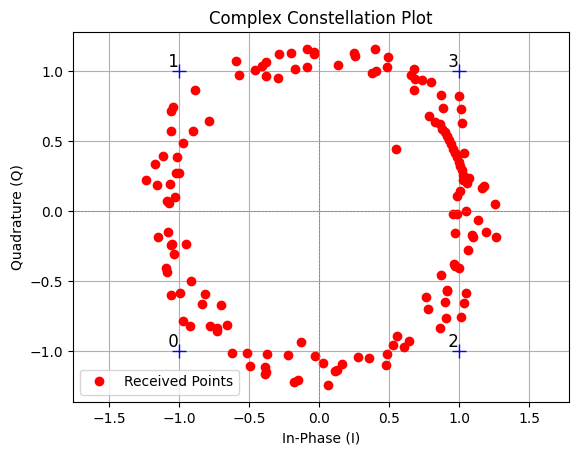

In [48]:
sp.plot_complex_points(rk, constellation=qpsk_constellation)

&nbsp;
#### Carrier Phase Synchronization

A PLL object is first instantiated using the system sample rate, specified loop bandwidth, and damping factor as well as a number of internal tracking record arrays.

In [49]:
loop_bandwidth = (fc/fs)*0.02
damping_factor = 1/np.sqrt(2)
pll = sp.PLL(fs, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor)

# internal tracking records
pll_detected_phase_record = []
pll_error_record = []
pll_loop_filter_record = []

# output tracking records
rotated_constellations = []
detected_constellations = []

#### Unique Word Resolution

To identify the received unique word and properly adjust the received constellations by the corresponding phase ambiguity, a shift register is used to search for the unique word while the PLL operates. Each incoming sample is inserted into the register, which is then checked against the phase ambiguity lookup table for a match. This process continues until a match is found, at which point the DDS output is adjusted to account for the identified ambiguity.

In [50]:
uw_register = ['0', '0', '0', '0', '0', '0', '0', '0']
uw_flag = False

dds_output = np.exp(1j * 0) # initial dds output
uw_offset = 0 # initial unique word offset

Before running the subsystem, the maximum system gain must be measured and normalized. This is performed by running the PLL in open loop mode by setting the *open_loop* flag to *True* and recording the maximum value.

In [51]:
pll = sp.PLL(fs, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor, open_loop=True)

max_lf_output = 0
for i in range(len(rk)):
    lf_output = pll.insert_new_sample(rk[i], i)
    if lf_output > max_lf_output:
        max_lf_output = lf_output

pll_gain = max_lf_output
print(f"\nPLL Measured System Gain: {pll_gain}\n")


PLL Measured System Gain: 0.13441811524648387



The PLL module is the reinstantiated using this gain as well as a number of arrays defined to track internal variables.

In [52]:
pll = sp.PLL(fs, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor, gain=pll_gain)

pll_error_record = []
rotated_constellations = []
detected_constellations = []
dds_output = np.exp(1j * 0)

The PLL is now run using the received signal constellation points as input and producing synchronized constellation points as output.

In [55]:
for i in range(len(rk)):
    # perform ccw rotation
    rk_ccwr = rk[i] * dds_output * np.exp(1j * uw_offset)
    rotated_constellations.append(rk_ccwr)

    # find nearest neighbor constellation
    detected_symbol = sp.nearest_neighbor([rk_ccwr], qpsk_constellation)[0]
    detected_constellation = bits_to_amplitude[detected_symbol]
    detected_constellations.append(detected_constellation)

    # update unique word register
    uw_register.pop(0)
    uw_register.append(str(detected_symbol))

    if uw_flag == False:
        received_unique_word = sp.check_unique_word(uw_register, phase_ambiguities=phase_ambiguities)
        if received_unique_word != None:
            uw_offset = received_unique_word
            uw_flag = True

    # calculate phase error
    phase_error = pll.phase_detector(rk_ccwr, detected_constellation)
    pll_error_record.append(phase_error)
    
    # feed into loop filter
    loop_filter_output = pll.loop_filter(phase_error)

    # generate next dds output
    dds_output = np.exp(1j * loop_filter_output)

TypeError: check_unique_word() got an unexpected keyword argument 'phase_ambiguities'

The rotated constellation points are plotted to illustrate the subsystems performance as well as the received unique word ambiguity printed.

Phase Ambiguity Rotation: 0.0 deg



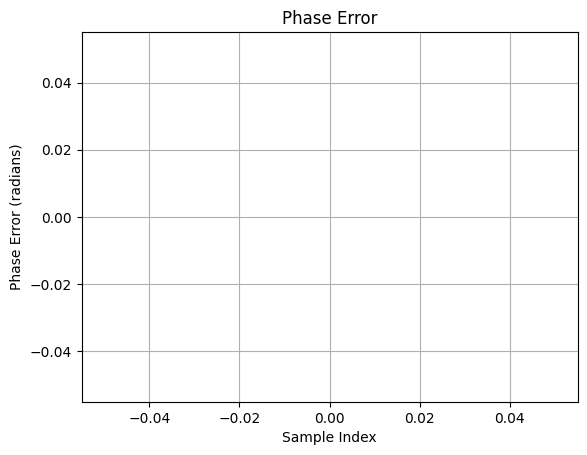

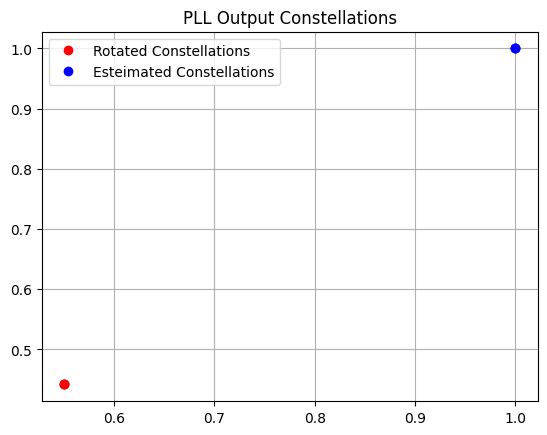

In [56]:
print(f"Phase Ambiguity Rotation: {np.degrees(uw_offset)} deg\n")

# phase error and constellation plotting
plt.figure()
plt.plot(pll_error_record, label='Phase Error', color='r')
plt.title('Phase Error')
plt.xlabel('Sample Index')
plt.ylabel('Phase Error (radians)')
plt.grid()
plt.show()

plt.title("PLL Output Constellations")
plt.plot(np.real(rotated_constellations), np.imag(rotated_constellations), 'ro', label="Rotated Constellations")
plt.plot(np.real(detected_constellations), np.imag(detected_constellations), 'bo',  label="Esteimated Constellations")
plt.legend()
plt.grid(True)
plt.show()

#### Symbol Decision

The phase symchronized signal can now be mapped back from constellation points to symbols via the nearest neighbor algorithm, this process is discussed more thoroughly in the *QPSK.ipynb* notebook.

In [62]:
detected_symbols = sp.nearest_neighbor(detected_constellations[len(header) + len(unique_word):], qpsk_constellation)
symbol_errors = sp.error_count(input_message_symbols[len(unique_word):], detected_symbols)
print(f"Transmission Symbol Errors: {symbol_errors}")
print(f"Bit Error Percentage: {round((symbol_errors * 2) / len(detected_symbols), 2)} %")

Transmission Symbol Errors: 82


ZeroDivisionError: division by zero

Finally the estimated receive symbols are converted back to binary representations and then grouped into ascii characters.

In [63]:
# converting symbols to binary then binary to ascii
detected_bits = []
for symbol in detected_symbols:
    detected_bits += ([*bin(symbol)[2:].zfill(2)])

message = sp.bin_to_char(detected_bits)
print(message)
